In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
import os
import numpy as np
# Paths a los datos descargados

TRAIN_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/Data/Train/"
VAL_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/Data/Validation/"
TEST_IMAGES_DIR = "dlmi-uba/practica3/data/Test/Images/"
TEST_LABELS_DIR = "dlmi-uba/practica3/data/Test/Labels/"

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.transform as trans

import os
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def adjustData(img, mask):
    img = img / 255.
    
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def trainGenerator(batch_size, train_path, image_folder, mask_folder, 
                   aug_dict, 
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale", 
                   image_save_prefix  = "image", 
                   mask_save_prefix  = "mask",
                   save_to_dir = None, 
                   target_size = (256, 256),
                   seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
#        img,mask = adjustData(img,mask)
        yield (img,mask)

Using TensorFlow backend.


# Definición del modelo

Acá procedemos a definir el modelo U-Net a utilizar.

In [3]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import keras

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

  
def unet(pretrained_weights = None, input_size = (256,256,3)):
    
    inputs = Input(input_size)
    
    # Implementar un U-Net que tenga:
    # - Relu como función de activación
    # - 4 niveles de MaxPooling de 2x2
    # - Que utilice 'he' como método de incialización de pesos: kernel_initializer = 'he_normal'
    
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    #por que cambia el kernel de 2 a 3
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    out = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(input = inputs, output = out )

    # Compilar el modelo usando Adam como algoritmo de optimización, con learning rate = 1e-5
    model.compile(optimizer = Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    print("Model created")
    return model



In [13]:
# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    n_ch_exps = [4, 5, 6]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256

    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        #print(l_idx, enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [14]:

# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [mean_iou]
num_gpus = 0

# Compile our model
model = unet_model(img_width=128, img_height=128)
model.summary()

# For more GPUs
if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6]
[5, 4]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

# Entrenar el modelo

A continuación, entrenaremos el modelo usando el método 'fit_generator' de Keras.


In [5]:
# Based on: https://github.com/zhixuhao/unet/blob/master/main.py

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Diccionario conteniendo los parámetros para la aumentación de datos

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    )

# Generador para los datos de training
trainGen = trainGenerator(2, TRAIN_DATA_DIR,'image','label',data_gen_args, save_to_dir = None, target_size = (128, 128))

# Generador para los datos de test
#valGen = valGenerator(2, VAL_DATA_DIR,'image','label', save_to_dir = None, target_size = (128, 128))

model = unet(input_size = (128, 128, 3))
#model_checkpoint = ModelCheckpoint('unet_CMR.hdf5', monitor='loss', verbose=1, save_best_only=True)

history = model.fit_generator(trainGen, 
                              steps_per_epoch=20, 
                              epochs=10) 
                              #callbacks=[model_checkpoint], 
                              #validation_data=valGen, 
                              #validation_steps=10)


/anaconda3/envs/ACDC3/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


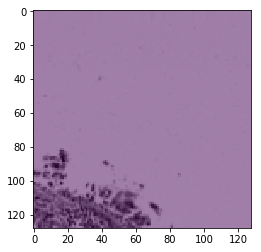

In [8]:
num_batch = 1
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    )

myGenerator = trainGenerator(1,
                             TRAIN_DATA_DIR,
                             'image',
                             'label',
                             data_gen_args,
                             save_to_dir = None,
                             target_size = (128, 128))


for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break
        
for i in range(batch[0].shape[0]):
    plt.imshow(batch[1][i][:,:,0])
    plt.imshow(batch[0][i][:,:,0]*250, cmap='gray',alpha=0.5)
    plt.show()

In [9]:
batch[0].shape

(1, 128, 128, 3)